<a id="top"></a>
# MICCAI 2017 Robotic Instrument Segmentation


## Prerequisites
This sample requires the following:
- All files are present and in the following directory structure:
    
    - **robotic-surgery-segmentation.ipynb** - This Jupyter* Notebook
    - **figues/segmentation.gif,TernausNet.png** - Images that appear in this Jupyter* Notebook
    - **python/\*** - Python* code for all aspects of the robotic instrument segmentation application:<br>
    -- **figures.py** - Generates visualization for steps of segmentation performed<br>
    -- **models.py** - Contains different models as Python* code<br>
    -- **pytorch_to_onnx.py** - Converts PyTorch* to ONNX* model<br>
    -- **img_to_video.py** - Converts multiple images into a video file<br>
    -- **pytorch_infer.py** - Runs inference using PyTorch\*<br>
    -- **segmentation_parts.py** - Robotic instrument segmentation application code<br>
    -- **utils.py** - Utility functions<br>
    -- **run_py.sh** - Utility shell script to run Python* files from jobs<br>
    -- **quantize.py** - Converts OpenVINO FP32 to INT8 model<br>
    - **data/short_source.mp4** - Test video
    - **data/frame.png,left_framge.png,right_frame.png** - Used for visualization 
    - **/data/robotic-instrument-segmentation/unet11_\*_20/model_0.pt** - Trained U-Net model data for different approaches (binary, parts, instruments - "parts" will be used)
    

It is recommended that you have already read the following from [Get Started on the Intel® DevCloud for the Edge](https://devcloud.intel.com/edge/home/):
- [Overview of the Intel® DevCloud for the Edge](https://devcloud.intel.com/edge/get_started/devcloud/)
- [Overview of the Intel® Distribution of OpenVINO™ toolkit](https://devcloud.intel.com/edge/get_started/openvino/)

<br><div class=note><i><b>Note: </b>It is assumed that the server this sample is being run on is on the Intel® DevCloud for the Edge which has Jupyter* Notebook customizations and all the required libraries already installed.  If you download or copy to a new server, this sample may not run.</i></div>


## Introduction

This sample application demonstrates how a smart video IoT solution may be created using Intel® hardware and software tools to perform robotic instrument segmentation.  This solution performs semantic segmentation to identify the segments of robotic instruments within a video frame.  The identified robotic instruments segments are then highlighted in the output with each segment appearing in a different color.

### Key concepts
This sample application includes an example for the following:
- Application:
  - Video and image input is supported using OpenCV
  - OpenCV is used to draw bounding boxes around detected objects, labels, and other information
  - Visualization of the resulting segmentation in the output
- Intel® DevCloud for the Edge:
  - Submitting inference as jobs that are performed on different edge compute nodes (rather than on the development node hosting this Jupyter* notebook)
  - Monitoring job status
  - Viewing results and assessing performance for hardware on different compute nodes
- [Intel® Distribution of OpenVINO™ toolkit](https://software.intel.com/openvino-toolkit):
  - Create the necessary Intermediate Representation (IR) files for the inference model using [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html)
  - Run an inference application on multiple hardware devices using the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)


### Application background
![Robotic Instrument Challenge](./figures/segmentation.gif)

The code in this sample refers to the winning solution by Alexey Shvets, Alexander Rakhlin, Alexandr A. Kalinin, and Vladimir Iglovikov in the [MICCAI 2017 Robotic Instrument Segmentation Challenge](https://endovissub2017-roboticinstrumentsegmentation.grand-challenge.org/). This Jupyter* Notebook has been modified from the original found on [GitHub](https://github.com/ternaus/robot-surgery-segmentation/blob/master/Demo.ipynb) which is made available with an [MIT license](https://github.com/ternaus/robot-surgery-segmentation/blob/master/LICENSE). The data files necessary to run this notebook are included in `/data/robotic-surgery-segmentation`.

## Robotic instrument segmentation application
The robotic instrument segmentation application uses the Intel® Distribution of OpenVINO™ toolkit to perform inference on an input video to locate robotic instruments within each frame.  We will setup, run, and view the results for this application for several different hardware devices (CPU. GPU, etc.) available on the compute nodes within the Intel® DevCloud for the Edge.  To accomplish this, we will be performing the following tasks:

1. Use the [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to create the inference model IR files needed to perform inference
2. Create the job file used to submit running inference on compute nodes
3. Submit jobs for different compute nodes and monitor the job status until complete
4. View results and assess performance 

### How it works
At startup the robotic instrument segmentation application configures itself by parsing the command line arguments.  Once configured, the application loads the specified inference model's IR files into the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) and runs inference on the specified input video to identify segments of robotic instruments.  Once identified, each robotic instrument segment is colored to highlight it on the output video.

To run the application on the Intel® DevCloud for the Edge, a job is submitted to an edge compute node with a hardware accelerator such as Intel® HD Graphics GPU and Intel® Movidius™ Neural Compute Stick 2.  After inference on the input is completed, the output is stored in the appropriate `results/<architecture>/` directory.  The results are then viewed within this Jupyter* Notebook using the `videoHTML` video playback utility.

The application and inference code for this sample is already implemented in the Python* file [`segmentation_parts.py`](./python/segmentation_parts.py) (and other helper `python/*.py` files).

The following sections will guide you through configuring and running the robotic instrument segmentation application.

## Install the required packages

In [41]:
# ! $sys.executable -m pip install opencv-python-headless matplotlib onnx Pillow scipy tqdm pyyaml networkx pandas chainer addict hyperopt pymongo test-generator==0.1.1 progress
# ! pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
!pip install test-generator==0.1.1

  Using cached test_generator-0.1.1-py2.py3-none-any.whl (5.5 kB)


## Imports
We begin by importing all the Python* modules that will be used within this Jupyter* Notebook to run and display the results of the robotic instrument segmentation application on the Intel® DevCloud for the Edge:
- [cv2](https://opencv.org/) - Python* OpenCV module
- [os](https://docs.python.org/3/library/os.html#module-os) - Operating system specific module (used for file name parsing)
- [time](https://docs.python.org/3/library/time.html#module-time) - Time tracking module (used for measuring execution time)
- [matplotlib.pyplot](https://matplotlib.org/) - pyplot is used for displaying output images
- [sys](https://docs.python.org/3/library/sys.html#module-sys) - System specific parameters and functions
- [python.utils](./python/utils.py) - Provides utilities for displaying results within this Jupyter* Notebook

Run the following cell to import the Python* dependencies needed.

<br><div class=tip><b>Tip: </b>Select a cell and then use **Ctrl+Enter** to run that cell. **Shift+Enter** runs the cell and moves to the next cell.</div>

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import time
import sys
import torch
from python.utils import create_script, mask_overlay
from openvino.inference_engine import IECore
import numpy as np
from io import BytesIO
import PIL
import IPython.display
from python.quantize import DatasetsDataLoader, video_to_frames

from python.models import UNet11
print('Imported Python modules successfully.')

14:49:15 accuracy_checker WARNING: c:\Program Files (x86)\intel\openvino_2021\deployment_tools\tools\post_training_optimization_toolkit\libs\open_model_zoo\tools\accuracy_checker\accuracy_checker\launcher\input_feeder.py:58: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'STR': np.str,  # string

14:49:16 accuracy_checker WARNING: c:\Program Files (x86)\intel\openvino_2021\python\python3.7\ngraph\utils\types.py:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in 

Imported Python modules successfully.


## Converting PyTorch* to ONNX*

The ONNX* models need to be generated from the original PyTorch* models to be used with the Intel® Distribution of OpenVINO™ toolkit.  This is done by running [pytorch_to_onnx.py](python/pytorch_to_onnx.py). 


In [3]:
model_dir = os.path.join(os.path.abspath(os.curdir), 'models')
source_model_path_binary = os.path.join(model_dir, 'torch', 'unet11_binary_20', 'model_0.pt')
onnx_path_binary = os.path.join(model_dir, 'onnx', 'surgical_tools.onnx')

source_model_path_parts = source_model_path_binary.replace('binary','parts')
onnx_path_parts = onnx_path_binary.replace('tools', 'tools_parts')

os.makedirs(os.path.dirname(onnx_path_binary), exist_ok=True)

os.makedirs(os.path.dirname(onnx_path_parts), exist_ok=True)

14:49:19 accuracy_checker WARNING: c:\users\havanden\no_openvino_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [20]:
source_model_binary = UNet11()
checkpoint_binary = torch.load(source_model_path_binary, map_location=torch.device('cpu'))
checkpoint_binary = {key.replace('module.', ''): value for key, value in checkpoint_binary['model'].items()}
source_model_binary.load_state_dict(checkpoint_binary)
source_model_binary.eval();

In [21]:
source_model_parts = UNet11(num_classes=4)
checkpoint_parts = torch.load(source_model_path_parts, map_location=torch.device('cpu'))
checkpoint_parts = {key.replace('module.', ''): value for key, value in checkpoint_parts['model'].items()}
source_model_parts.load_state_dict(checkpoint_parts)
source_model_parts.eval();

In [22]:
dummy_input = torch.randn(1, 3, 1024, 1280)
torch.onnx.export(source_model_binary, dummy_input, onnx_path_binary, opset_version=11)
torch.onnx.export(source_model_parts, dummy_input, onnx_path_parts, opset_version=11)

<br><div class=danger><b>Wait!: </b>
Please wait for the progress bar and job to complete before proceeding to the next cell.
</div>

The two ONNX* models that have now be generated are:
- **models/onnx/surgical_tools_parts.onnx** - Segmentation model used for identifying robotic instrument segments ("parts")
 - This model will be used to process video and measure performance in later steps 
- **models/onnx/surgical_tools.onnx** - Segmentation model used for identifying robotic instrument ("binary")
 - This model, along with the `surgical_tools_parts.onnx`, will be used in an extra inference run to show some visualization of the segmentation involved.

#### Configure input
For convenience and consistency, in the next cell we set the Python* variable `InputVideo` to the input video file we will be using to run our sample application.

<br><div class=note><i><b>Note: </b>
If you want to use a different input video, change the path in the following cell to the path of the video and run the cell again.
</i></div>

In [11]:
# Set the path to the input video to use for the rest of this sample
InputVideo = "data/short_source.mp4"
print(f"Input video file set to:{InputVideo}")

Input video file set to:data/short_source.mp4


In [12]:
cap = cv2.VideoCapture(InputVideo)

In [13]:
ret, frame = cap.read()

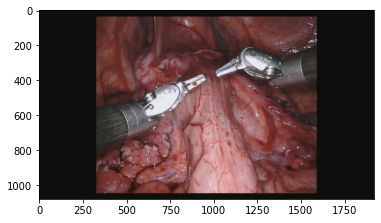

In [14]:
plt.imshow(frame[:,:,(2,1,0)])

In [19]:
import mo_onnx
mo_path = mo_onnx.__file__
mo_path_str = rf'"{mo_path}"'
mo_path, mo_path_str

('c:\\Program Files (x86)\\intel\\openvino_2021\\deployment_tools\\model_optimizer\\mo_onnx.py',
 '"c:\\Program Files (x86)\\intel\\openvino_2021\\deployment_tools\\model_optimizer\\mo_onnx.py"')

In [5]:
openvino_model_dir = os.path.abspath(os.path.join('models','ov'))
os.makedirs(openvino_model_dir, exist_ok=True)

In [6]:
! $sys.executable  $mo_path_str --input_model $onnx_path_parts --output_dir $openvino_model_dir

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	C:\Users\havanden\code\openvino-notebooks\surgery_segmentation\models\onnx\surgical_tools_parts.onnx
	- Path for generated IR: 	C:\Users\havanden\code\openvino-notebooks\surgery_segmentation\models\ov
	- IR output name: 	surgical_tools_parts
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
ONNX specific parameters:
Model Optimizer version: 	2021.2.0-1877-176bdf51370-releases/2021/2

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: C:\

## Inference on one frame

In [7]:
# Load network to the plugin
ie = IECore()
net_onnx = ie.read_network(model=onnx_path_parts)
exec_net_onnx = ie.load_network(network=net_onnx, device_name="CPU")
del net_onnx

input_layer_onnx = next(iter(exec_net_onnx.input_info))
output_layer_onnx = next(iter(exec_net_onnx.outputs))

# Run the Inference on the Input image...
# res_onnx = exec_net_onnx.infer(inputs={input_layer_onnx: input_image})
# res_onnx = res_onnx[output_layer_onnx]


### View results

Once the jobs have completed, the queue system outputs the stdout and stderr streams of each job into files with names of the forms <*JobName*>.o<*JobID*> and <*JobName*>.e<*JobID*>, respecitvely.  The *JobName* corresponds to the `-N` option when submitting the job using the `qsub` command.  

The output video file for each job is written to the file `output.mp4` located in the directory `results/<device>` that was specified as the output directory to the job file.  We will now use the `videoHTML()` utility to display the output video files within this Jupyter* notebook.  Calling `videoHTML()` from a Python* cell follows the form:
```python
videoHTML(title, [list_of_video_files], statistics(optional))
```
The parameters are:
- *title* - Title to put at the top of the displayed output
- \[*list_of_video_files*\] - Python* list of video files to display
- *statistics(optional)* - Optional statistics file containing the number of seconds it took to process a number of frames

Run the cells below to display the videos.



In [8]:
def crop(image, size=(1024,1280)):
    """
    Helper function to crop the image
    """
    cropHeight, cropWidth = size
    imgHeight, imgWidth = image.shape[0], image.shape[1] 
    startH = (imgHeight - cropHeight) // 2
    startW = (imgWidth - cropWidth) // 2
    return image[startH:(startH+cropHeight),startW:(startW+cropWidth),:]

In [9]:
def showarray(a, prev_display_id=None, fmt="jpeg"):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if prev_display_id is not None:
        IPython.display.update_display(obj, display_id=prev_display_id)
        return prev_display_id
    else:
        return IPython.display.display(obj, display_id=True).display_id

In [10]:
cap = cv2.VideoCapture(InputVideo)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


NameError: name 'InputVideo' is not defined

In [ ]:
display_id = None

cap = cv2.VideoCapture(InputVideo)
for number in range(num_frames):
    # Grab the next frame from the video feed, quit if none
    ret, image = cap.read()
    if not ret:
        break

    # Resize the input image to match the expected value
    image = crop(image)
    image_rgb = image[:,:,np.argsort([2,1,0])]

    # Run the inference
    res = exec_net_onnx.infer(inputs={input_layer_onnx : np.expand_dims(np.transpose(image_rgb/255.0, [2, 0, 1]), 0)}) 

    # Create a mask using the predicted classes	
    mask_frame = np.zeros((1024,1280,3), dtype=np.uint8)
    #frame = res[output_layer_onnx][0,0]
    #mask_frame[frame > 0] = [0,255,0] 

    frame = res[output_layer_onnx]
    sliced = frame[0,1:,:,:]
    mask_frame = (np.floor(np.transpose(sliced, [1,2,0])*255)).astype(np.uint8)

    
    # Write out frame to video 
    merged = cv2.addWeighted(image, 1, mask_frame, 0.5, 0)
    
    display_id = showarray(merged, None if display_id is None else display_id)


cap.release()

## Quantization

Quantization is the process of reducing the model's precision. By performing this optimization, you can accelerate your model execution time.  

[quantize.py](python/quantize.py) file contains quantization script and uses the [post training optimization toolkit (POT) API](https://docs.openvinotoolkit.org/latest/pot_compression_api_README.html) to reduce model's precision from FP32 to INT8. Quantization settings, such as the path to original model, path to dataset, quantization algorithm etc., which should be set via configs. ```DatasetsDataLoader``` creates quantization dataset from the sample video and loads one by one input images to POT, when quantization process starts. When quantization is finished, the INT8 model will be saved at ```'/models/ov/INT8'``` directory.

Run the following cell to create the ```quantization_job.sh``` job file. This script runs quantization and benchmarking of the quantized and non-quantized models to compare their execution time.

In [15]:
from pathlib import Path

In [45]:
Path(work_directory + '/models/ov/surgical_tools_parts.xml')

WindowsPath('C:/Users/havanden/code/openvino-notebooks/surgery_segmentation/models/ov/surgical_tools_parts.xml')

In [49]:
ie = IECore()
net = ie.read_network('C:/Users/havanden/code/openvino-notebooks/surgery_segmentation/models/ov/surgical_tools_parts.xml', 'C:/Users/havanden/code/openvino-notebooks/surgery_segmentation/models/ov/surgical_tools_parts.bin')
exec_net = ie.load_network(net, 'CPU')
del net

In [53]:
result = exec_net.infer(inputs={next(iter(exec_net.input_info.keys())): None})

In [16]:

from addict import Dict
from compression.graph import load_model, save_model
from compression.api.data_loader import DataLoader
from compression.engines.ie_engine import IEEngine
from compression.pipeline.initializer import create_pipeline

work_directory=os.path.abspath(os.curdir)

# Dictionary with the FP32 model info
model_config = Dict({
    'model_name': 'surgical_tools_parts',
    'model': Path(work_directory + '/models/ov/surgical_tools_parts.xml'),
    'weights': Path(work_directory + '/models/ov/surgical_tools_parts.bin'),
})

# Dictionary with the engine parameters
engine_config = Dict({
    'device': 'CPU',
    'stat_requests_number': 4,
    'eval_requests_number': 4
})

dataset_config = Dict({
    'data_source': work_directory + '/data/short_source.mp4', # Path to input data for quantization
})

# Quantization algorithm settings
algorithms = [
    {
        'name': 'DefaultQuantization', # Optimization algorithm name
        'params': {
            'target_device': 'CPU',
            'preset': 'performance', # Preset [performance (default), accuracy] which controls the quantization mode 
                                     # (symmetric and asymmetric respectively)
            'stat_subset_size': 300  # Size of subset to calculate activations statistics that can be used
                                     # for quantization parameters calculation.
        }
    }
]

# Load the model.
model = load_model(model_config)

# Initialize the data loader.
data_loader = DatasetsDataLoader(dataset_config)

# Initialize the engine for metric calculation and statistics collection.
engine = IEEngine(engine_config, data_loader, None)

# Create a pipeline of compression algorithms.
pipeline = create_pipeline(algorithms, engine)

# Execute the pipeline.
compressed_model = pipeline.run(model)

# Save the compressed model.
save_model(compressed_model, work_directory + '/models/ov/INT8')

14:50:12 accuracy_checker WARNING: c:\Program Files (x86)\intel\openvino_2021\deployment_tools\model_optimizer\mo\utils\ir_engine\ir_engine.py:309: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'BOOL': (1, np.bool),

14:50:12 accuracy_checker WARNING: c:\Program Files (x86)\intel\openvino_2021\deployment_tools\model_optimizer\mo\front\common\partial_infer\concat.py:49: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance:

[{'model': 'C:\\Users\\havanden\\code\\openvino-notebooks\\surgery_segmentation/models/ov/INT8\\surgical_tools_parts.xml',
  'weights': 'C:\\Users\\havanden\\code\\openvino-notebooks\\surgery_segmentation/models/ov/INT8\\surgical_tools_parts.bin'}]

In [28]:
benchmark_app = os.path.join(os.path.dirname(os.path.dirname(mo_path)), 'tools', 'benchmark_tool', 'benchmark_app.py')
benchmark_app_str = rf'"{benchmark_app}"'


In [30]:
!pip install progress

  Using cached progress-1.5-py3-none-any.whl


In [35]:
str(Path(work_directory + 'models/ov/FP16/surgical_tools_parts.xml'))

'C:\\Users\\havanden\\code\\openvino-notebooks\\surgery_segmentationmodels\\ov\\FP16\\surgical_tools_parts.xml'

In [40]:
# # Run the benchmark_app for FP32 model
model_path = str(Path(work_directory + '/models/ov/surgical_tools_parts.xml'))
! $sys.executable $benchmark_app_str -m $model_path

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading Inference Engine
[ INFO ] InferenceEngine:
         API version............. 2.1.2021.2.0-1877-176bdf51370-releases/2021/2


c:\Program Files (x86)\intel\openvino_2021\python\python3.7\openvino\tools\benchmark\main.py:29: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(" -nstreams default value is determined automatically for a device. "
c:\Program Files (x86)\intel\openvino_2021\python\python3.7\openvino\tools\benchmark\utils\inputs_filling.py:71: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("No input files were given: all inputs will be filled with random values!")


[ INFO ] Device info
         CPU
         MKLDNNPlugin............ version 2.1
         Build................... 2021.2.0-1877-176bdf51370-releases/2021/2

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance,but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] Reading network files
[ INFO ] Read network took 209.38 ms
[Step 5/11] Resizing network to match image sizes and given batch
[ INFO ] Network batch size: 1
[Step 6/11] Configuring input of the model
[Step 7/11] Loading the model to the device
[ INFO ] Load network took 740.24 ms
[Step 8/11] Setting optimal runtime parameters
[Step 9/11] Creating infer requests and filling input blobs with images
[ INFO ] Network input 'input.1' precision U8, dimensions (NCHW): 1 3 1024 1280
[ WARNING ] No input files were given: all inputs will be filled with r

Run the following cell to start quantization and benchmarking of the quantized model on Xeon Gold 6258R.

In [42]:
model_path = str(Path(work_directory + '/models/ov/INT8/surgical_tools_parts.xml'))
! $sys.executable $benchmark_app_str -m $model_path

[Step 1/11] Parsing and validating input arguments

c:\Program Files (x86)\intel\openvino_2021\python\python3.7\openvino\tools\benchmark\main.py:29: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(" -nstreams default value is determined automatically for a device. "
c:\Program Files (x86)\intel\openvino_2021\python\python3.7\openvino\tools\benchmark\utils\inputs_filling.py:71: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("No input files were given: all inputs will be filled with random values!")



[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading Inference Engine
[ INFO ] InferenceEngine:
         API version............. 2.1.2021.2.0-1877-176bdf51370-releases/2021/2
[ INFO ] Device info
         CPU
         MKLDNNPlugin............ version 2.1
         Build................... 2021.2.0-1877-176bdf51370-releases/2021/2

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance,but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] Reading network files
[ INFO ] Read network took 261.00 ms
[Step 5/11] Resizing network to match image sizes and given batch
[ INFO ] Network batch size: 1
[Step 6/1

In this demo only 20 images were used for the model's quantization from FP32 to INT8. 
To achieve better accuracy, more data should be processed in quantization process to collect more robust statistics.

## Next steps
- [More Jupyter* Notebook Samples](https://devcloud.intel.com/edge/advanced/sample_applications/) - additional sample applications 
- [Jupyter* Notebook Tutorials](https://devcloud.intel.com/edge/get_started/tutorials) - sample application Jupyter* Notebook tutorials
- [Intel® Distribution of OpenVINO™ toolkit Main Page](https://software.intel.com/openvino-toolkit) - learn more about the tools and use of the Intel® Distribution of OpenVINO™ toolkit for implementing inference on the edge


## About this notebook

For technical support, please see the [Intel® DevCloud Forums](https://software.intel.com/en-us/forums/intel-devcloud-for-edge)

## Citation
    @inproceedings{shvets2018automatic,
    title={Automatic Instrument Segmentation in Robot-Assisted Surgery using Deep Learning},
    author={Shvets, Alexey A and Rakhlin, Alexander and Kalinin, Alexandr A and Iglovikov, Vladimir I},
    booktitle={2018 17th IEEE International Conference on Machine Learning and Applications (ICMLA)},
    pages={624--628},
    year={2018}
    }
<br><div class=note><i><b>Note: </b>Citation appears exactly as it appears on source website</i></div>

<p style=background-color:#0071C5;color:white;padding:0.5em;display:table-cell;width:100pc;vertical-align:middle>
<img style=float:right src="https://devcloud.intel.com/edge/static/images/svg/IDZ_logo.svg" alt="Intel DevCloud logo" width="150px"/>
<a style=color:white>Intel® DevCloud for the Edge</a><br>   
<a style=color:white href="#top">Top of Page</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Intel-DevCloud-for-the-Edge-Usage-Agreement.pdf">Usage Agreement (Intel)</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Colfax_Cloud_Service_Terms_v1.3.pdf">Service Terms (Colfax)</a>
</p>